In [1]:
import src.acquire
import src.prepare
import src.explore
import src.model

In [2]:
path='zillow_df.csv'

df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = src.prepare.wrangle_zillow(path)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((12224, 15), (5240, 15), (4366, 15))

In [3]:
df.shape

(21830, 19)

In [4]:
# Code to run before explore and modeling
X_train_explore.rename(columns = {'Unnamed: 0':'delete', 'id.1':'delete1'}, inplace = True)
X_train_explore.drop(columns = ['delete','delete1','yearbuilt'], inplace = True)
X_train_scaled.rename(columns = {'Unnamed: 0':'delete', 'id.1':'delete1'}, inplace = True)
X_train_scaled.drop(columns = ['delete','delete1'], inplace = True)
X_validate_scaled.rename(columns = {'Unnamed: 0':'delete', 'id.1':'delete1'}, inplace = True)
X_validate_scaled.drop(columns = ['delete','delete1'], inplace = True) 
X_test_scaled.rename(columns = {'Unnamed: 0':'delete', 'id.1':'delete1'}, inplace = True)
X_test_scaled.drop(columns = ['delete','delete1'], inplace = True)

#df.drop(labels=[1600, 1628, 5099, 5969, 8109, 8407, 8521, 8849, 11562, 12430, 14313, 20313, 21502], axis=0)

In [5]:
X_train_explore.shape

(12224, 16)

In [6]:
X_train_explore

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplace,garage,hottub_spa,lotsizesquarefeet,poolcnt,roomcnt,taxvaluedollarcnt,zip,useid,year,zip_cc,useid_cc,year_cc
11961,1.0,3.0,1480.0,1.0,1.0,0.0,6500.0,0.0,6.0,209045.0,97101.0,261.0,1938.0,360,4,51
13861,2.0,2.0,880.0,0.0,1.0,0.0,0.0,0.0,0.0,263933.0,97068.0,266.0,1997.0,348,8,110
17463,2.0,2.0,891.0,0.0,0.0,0.0,32915.0,0.0,0.0,223000.0,96341.0,266.0,1987.0,190,8,100
10288,1.0,2.0,819.0,0.0,0.0,0.0,6299.0,0.0,0.0,367511.0,96023.0,261.0,1922.0,38,4,35
11486,2.0,4.0,1614.0,0.0,0.0,0.0,5008.0,0.0,0.0,67469.0,96111.0,261.0,1956.0,80,4,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15223,3.0,5.0,2712.0,0.0,0.0,0.0,6142.0,0.0,0.0,509851.0,96356.0,269.0,1998.0,198,9,111
9390,3.0,4.0,2966.0,2.0,2.0,0.0,8050.0,1.0,9.0,638507.0,96987.0,261.0,1978.0,308,4,91
7485,3.0,3.0,2204.0,2.0,2.0,0.0,6000.0,0.0,6.0,598000.0,97107.0,261.0,1989.0,363,4,102
20811,3.0,3.0,1217.0,0.0,0.0,0.0,1351.0,0.0,0.0,275835.0,96378.0,269.0,1972.0,210,9,85


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# Explore

MVP- 3 Features
1. calculatedfinishedsquarefeet
2. bedroomcnt
3. bathroomcnt

Target = taxvaluedollarcnt

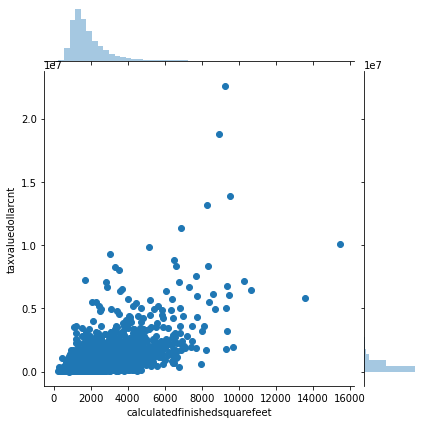

In [8]:
# Visualize relationship between square feet and tax value
sns.jointplot(x='calculatedfinishedsquarefeet',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

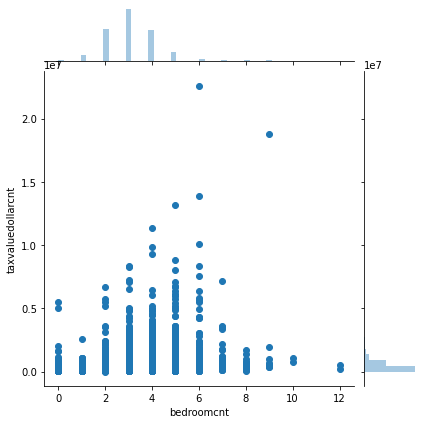

In [9]:
# Visualize relationship between bedroom count and tax value
sns.jointplot(x='bedroomcnt',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

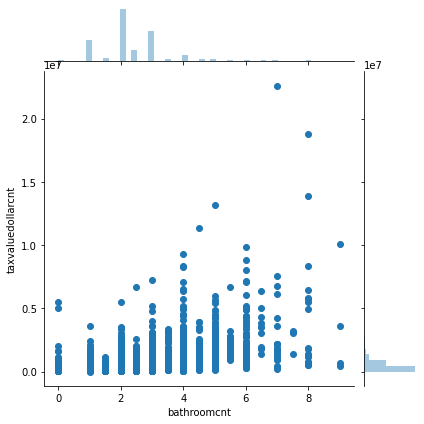

In [10]:
# Visualize relationship between square feet and bathroom cnt
sns.jointplot(x='bathroomcnt',y='taxvaluedollarcnt', data=X_train_explore)
plt.show()

#### Takeaway:

1. The only feature that appears to correlate wth the target in a linear fashion is calculatedfinishedsqure feet
2. Lets test if the featues are statistically significant to use

## Evaluate Linear Features

In [11]:
# This is the code for the Linear Model
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression, SelectKBest, RFE 

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5405360537296220.0
Model SSE 3504555115210110.5
SSE is 3504555115210110.5  which is the sum sf squared errors
MSE is 286694626571.50775  which is the average squared error
RMSE is 535438.7234516268  which is the square root of the MSE
R-squared =  0.352
p-value for model significance =  0.0
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


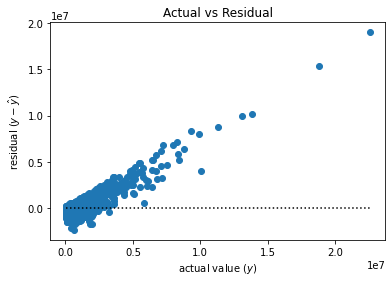

In [12]:
# Evaluate squre feet
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ calculatedfinishedsquarefeet', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.calculatedfinishedsquarefeet)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5405360537296220.0
Model SSE 5085474493158998.0
SSE is 5085474493158998.0  which is the sum sf squared errors
MSE is 416023764165.49396  which is the average squared error
RMSE is 644999.0419880436  which is the square root of the MSE
R-squared =  0.059
p-value for model significance =  3.731215748469814e-164
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


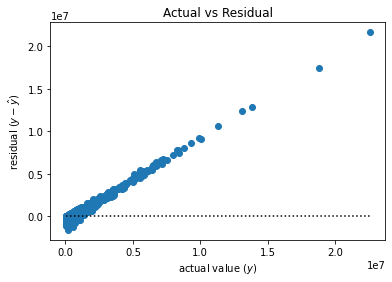

In [13]:
# Evaluate bedroom count
src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ bedroomcnt', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.bedroomcnt)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 5405360537296220.0
Model SSE 4194809160249808.0
SSE is 4194809160249808.0  which is the sum sf squared errors
MSE is 343161744130.3835  which is the average squared error
RMSE is 585800.0888787773  which is the square root of the MSE
R-squared =  0.224
p-value for model significance =  0.0
Reject Null: The model bulit on indipendent variables explains the relationship, validates $r^2$


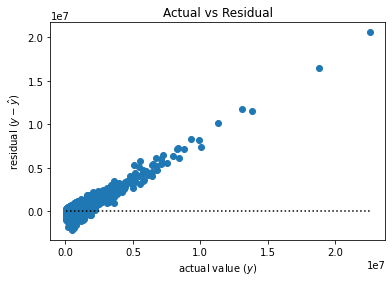

In [14]:
# Evaluate bathroom count

src.model.eval_linear_feature(ols('taxvaluedollarcnt ~ bathroomcnt', X_train_explore).fit(), X_train_explore.taxvaluedollarcnt, X_train_explore.bathroomcnt)

### Takaway:

- All 3 Variables pass F-test and are significant to use in our modeling

***

## Hypothesis Testing

***

#### Chi Squared Test For Independence:

**Hypothesis: There is a relationship between # of bedrooms and # of bathrooms that would make them a good canidate for future feature engeneering.**

Null Hypothesis: $H_{0}$: Number of Bedrooms and Number of Bathrooms are independent

Alternative Hypothesis: $H_{a}$: Number of Bedrooms and Number of Bathrooms are dependent


In [15]:
# Hypothesis Test

alpha = 0.05
contingency_table = pd.crosstab(X_train_explore.bedroomcnt, X_train_explore.bathroomcnt)

chi2, p, degf, expected = stats.chi2_contingency(contingency_table)

if p < alpha:
    print("We reject the null hypothesis")
    print(f'chi^2 = {chi2:.4f}')
    print(f'p     = {p:.4f}')
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis
chi^2 = 15792.8914
p     = 0.0000


#### Takeaway:

- Num. of bathrooms and Num. of bedrooms are related, and most likely would make an effective combined feature

***

***

# Modeling

Creating 4 Models to run on train dataset
1. Linear Regression
2. LassoLars
3. Polynomial Features
4. TweedieRegressor

In [16]:
# Models
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

### Create a Baseline

In [17]:
# Mean Value
np.mean(y_train)
y_train.shape

(12224, 1)

In [18]:
# encode as variable
# np.full modiefies shape turns value in to a full series object
baseline_rmse = mean_squared_error(y_train, np.full(12224, np.mean(y_train)))**(1/2)
baseline_rmse  # Model Error To Beat $665,000

664975.5276182499

***

# Train

***

### Linear Regression

In [19]:
# Make Model
lm = LinearRegression(normalize=True)
# Fit Model
lm.fit(X_train_scaled, y_train)
# Make Predictions
lm_pred = lm.predict(X_train_scaled)
# Compute root mean squared error
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lm_rmse

512459.52729677095

### LassoLars

In [20]:
# Make a model
lars = LassoLars(alpha=1)
# Fit a model
lars.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred = lars.predict(X_train_scaled)
# Computer root mean squared error
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lars_rmse

512460.1377839965

### Ploynomial Features

In [21]:
# Make a model
pf = PolynomialFeatures(degree=2)

# Fit and Transform model
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)

# Feed new features in to linear model. 
lm_squared = LinearRegression()
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

468471.51627777785

### Tweedie Regressor

In [22]:
# Make Model
tw = TweedieRegressor(power=0, alpha=0.1) # 0 = normal distribution
# Fit Model
tw.fit(X_train_scaled, y_train)
# Make Predictions
tw_pred = tw.predict(X_train_scaled)
# Compute root mean squared error
tw_rmse = mean_squared_error(y_train, tw_pred)**(1/2)
tw_rmse

625867.0183872326

***

### Takeaway:
- Top 3 preforming models are Linear, LassoLars, and Polynomial
- These modes will move on to Validate

***

# Validate

### Linear Regression

In [23]:
# Make Predictions
lm_pred_v = lm.predict(X_validate_scaled)
# Compute root mean squared error
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
lm_rmse_v

498755.6600779531

### LassoLars

In [24]:
# Make predictions
lars_pred_v = lars.predict(X_validate_scaled)
# Compute root mean squared error
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**(1/2)
lars_rmse_v

498744.6051919608

### Ploynomial Features

In [25]:
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute root mean squared error
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

18552253822558.047

***

### Takeaway:
- On unseen data Linear and  LassoLars preformed the test, error decreases indicates no overfitting
- Polynomial model error skyrocketed, indicates overfitt
- Evaluate LassoLars on Test

***

# Test

### LassoLars

In [26]:
# Make Predictions (On best Model)
lars_pred_test = lars.predict(X_test_scaled)
# Compute root mean squared error
lars_rmse_test = mean_squared_error(y_test, lars_pred_test)**(1/2)
lars_rmse_test

460545.7744742375

***

### Takeaway:
- LassoLars is 

***